In [ ]:
!python --version

Python 3.10.12


In [ ]:
%%capture --no-stderr
%pip install -U --quiet langgraph langsmith langchain_openai

In [ ]:
%pip install --upgrade --quiet  playwright > /dev/null
!playwright install-deps
!playwright install

Installing dependencies...
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packag

In [ ]:
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY="LANGCHAIN_TOKEN"
LANGCHAIN_PROJECT="webnavigator"

In [ ]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = LANGCHAIN_TRACING_V2
os.environ["LANGCHAIN_ENDPOINT"] = LANGCHAIN_ENDPOINT
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from typing import List, Optional
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]

class AgentState(TypedDict):
    page: Page
    input: str
    img: str
    bboxes: List[BBox]
    prediction: Prediction
    scratchpad: List[BaseMessage]
    observation: str

In [ ]:
import asyncio
import platform

async def click(state: AgentState):
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)

    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)

    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

In [ ]:
import base64

from langchain_core.runnables import chain as chain_decorator

with open("mark_page.js") as f:
    mark_page_script = f.read()

@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

In [ ]:
%pip install -U --quiet langchain_core langchain langchain_huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 18.8 MB/s eta 0:00:00


In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}

def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}

def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}

prompt = hub.pull("wfh/web-voyager:8b927604")

In [ ]:
%pip install --quiet langchain-groq
%pip install -qU langchain_mistralai
%pip install -qU langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.7 MB/s eta 0:00:00


In [ ]:
import os
from langchain_groq import ChatGroq
from langchain_mistralai import ChatMistralAI
from langchain_google_genai import ChatGoogleGenerativeAI

os.environ["GROQ_API_KEY"] = "GROQ_API"
os.environ["MISTRAL_API_KEY"] = "MISTRAL_API"
os.environ["GOOGLE_API_KEY"] = "GOOGLE_API"

"""
llm = ChatGroq(
    model="llama-3.2-11b-vision-preview",
)
"""
"""
llm = ChatMistralAI(
    model="pixtral-12b-2409",
)
"""

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro-002",
)

agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

In [ ]:
%pip install --quiet grandalf

print(agent.get_graph().draw_ascii())

                    +----------------+                 
                    | annotate_input |                 
                    +----------------+                 
                              *                        
                              *                        
                              *                        
                        +----------+                   
                        | annotate |                   
                        +----------+                   
                              *                        
                              *                        
                              *                        
               +---------------------------+           
               | Parallel<prediction>Input |           
               +---------------------------+           
                     **              ***               
                  ***                   **             
                **                        ***   

In [ ]:
import re
from langchain_core.messages import HumanMessage

def update_scratchpad(state: AgentState):
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        try:
            step = int(re.match(r"\d+", last_line).group()) + 1
        except AttributeError:
            step = 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"


    return {**state, "scratchpad": [HumanMessage(content=txt)]}

In [ ]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, START, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    action = state["prediction"]["action"]
    if action == "ANSWER;":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

In [ ]:
print(graph.get_graph().draw_ascii())

                                                                     +-----------+                                                                 
                                                                     | __start__ |                                                                 
                                                                     +-----------+                                                                 
                                                                           *                                                                       
                                                                           *                                                                       
                                                                           *                                                                       
                                                                  .....+-------+*****                           

In [ ]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
browser = await browser.chromium.launch(headless=True, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER;" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Type: ['9', 'What are the latest blog post from langchain?']
2. retry: Could not parse LLM Output: Thought:The first two search results are blog posts from Langchain, which satisfies the prompt.
Action:ANSWER; The latest blog posts from Langchain are "Unify Launches Agents for Account Qualification using LangGraph and LangSmith" and "By LangChain".

3. Click: ['22']
4. ANSWER;: ['Launching Long-Term Memory Support in LangGraph, Announcing LangChain v0.3, How Podium optimized agent behavior and reduced engineering intervention by 90% with LangSmith.']


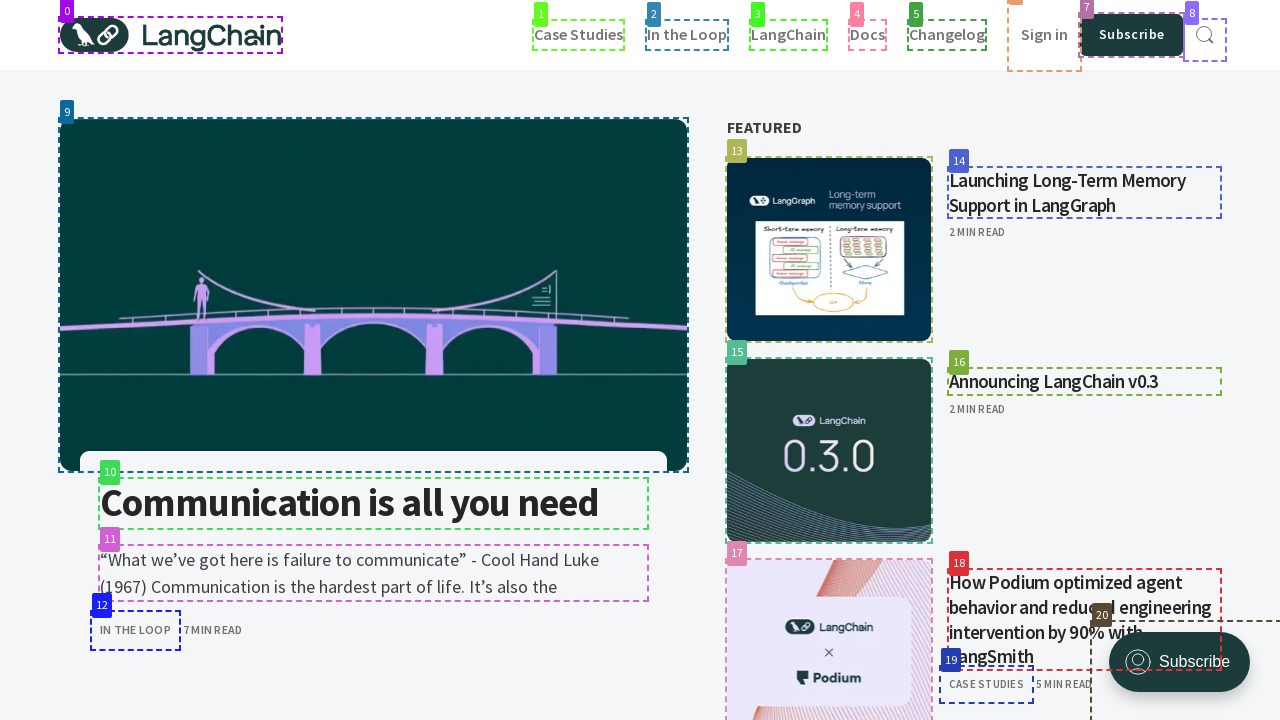

Final response: Launching Long-Term Memory Support in LangGraph, Announcing LangChain v0.3, How Podium optimized agent behavior and reduced engineering intervention by 90% with LangSmith.


In [ ]:
res = await call_agent("What are the latest blog post from langchain?", page)
print(f"Final response: {res}")